In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg

## Genetic Algorithm 

In this notebook, we write all the code we need to run a genetic algorithm. We build it from the bottom up.

### Support Code

We begin by copy-pasting the code from last lecture into this notebook

<ul>
<li>GAsettings: the class that allows us to store the settings for the genetic algorithm
<li>select_pool: the function that selects a breeding pool from a large population
<li>generateIndividual: the function that generates a random individual in parameter space
</ul>

In [2]:
# GASettings class
class GASettings:
    def __init__( self, numParents = 10, numChildren = 50 ):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.mutation = 0.05; # std of normal distribution computed as mutation*value
        self.eliteCount = 1;

## Copy-Paste select_pool

In [3]:
# Select pool
def select_pool( G, Gcost, settings ):
    """ Select a breding pool from the previous generation.
    G is numChildren x numParameters
    Gcost is numChildren long and is sorted in ascending order.
    Returns (P,Pcost)
    where 
    P is numParents x numParameters
    Pcost is numParents long.
    """
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )
    Pidxs = []
    if settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    elif settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    else:
        print( "Unknown selection operator: ", settings.selection )
    return (P, Pcost)

## Copy-Paste generateIndividual

In [4]:
# generateIndividual
def generateIndividual(cost_fcn, lb,ub):
    '''
    Generate a viable individual (i.e one whos cost function is finite)
    and return it and its cost.
    If 1000 tries fails to yield an individual, then the paramets and an infinite cost
    are returned.
    Each individual is generated by randomly chosing each entry params[i] 
    so that lb[i] <= params[i] <= ub[i]
    Input:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    '''
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

## Test with a simple cost function

This cost function simply captures the distance of an individual in 7-dimensional space to a particular point (1,5,2.5,2,4,3,0). We used this same function in the last lecture.

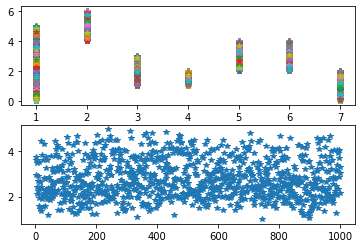

In [5]:
def pattern_cost_function( params ):
    return scipy.linalg.norm( params-np.array([1,5,2.5,2,4,3,0]) )

lam = 1000 # number of individuals in generation
mu = 100 # number of individuals in breeding pool
NP = 7 # num of parameters per individual
settings = GASettings(numParents=mu, numChildren=lam)

lb = np.array([0,4,1,1,2,2,0])
ub = np.array([5,6,3,2,4,4,2])
G = np.zeros( (lam,NP) )
Gcost = np.zeros( (lam,))
for i in range(lam):
    (G[i,:], Gcost[i]) = generateIndividual(pattern_cost_function,lb,ub)
    
plt.subplot( 2, 1, 1 )
plt.plot( np.arange(1,NP+1), G.T, '*');
plt.subplot( 2, 1, 2 )
plt.plot( np.arange(1,lam+1), Gcost, '*');

## Write generateChild

Write a function that take the cost function, breeding pool, lower bounds, upper bounds, and settings as input. It should generate children from the breeding pool using cross-over and mutation. 

<ul>
    <li>Initialize the return values (params is an np.array the same shape as lb and cost is np.inf).
    <li>For each attempt at making a child with finite code (allow 1000 attempts)
        <ul>
        <li>Choose a first parent from the breeding pool (choose an index between 0 and the number of rows in the breeding pool P).
        <li>Choose a second parent from the breeding pool (choose an index between 0 and the number of rows in the breeding pool P).    
        <li>Loop through the elements of the new child, randomly choosing one of the parents to inherit from.
        <li>Mutate each of the values in the child by adding a number that is chosen from a normal distribution centered at zero, with a standard deviation of settings.mutation*the_value_in_the_child
        <li>Make sure all of the values in the child are in bounds (>= lb and <= ub).
        <li>Compute the cost of the child.
        <li>If the cost is finite, return the child and its cost
    </ul>
    <li>If we tried 1000 times to create a child and never found one with a finite cost, just give up and return (np.zeros((lb.size)), np.inf)
</ul>

In [6]:
def generateChild(cost_fcn, P, lb, ub, settings):
    """
    Generate a viable child (i.e one whos cost function is finite)
    and return it and its cost function.
    If 1000 tries fails to yield a parent, then an infinite cost
    is returned.
    Input Parameters:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        P: parents (lam x NP ndarray of parameter values)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
        settings: a GASettings object
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    """
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range(1000):
        # Choose two parenst from the breeding pool.
        P1idx = np.random.choice(P.shape[0]);
        P1  = P[P1idx,:];
        P2idx = np.random.choice(P.shape[0]);
        P2  = P[P2idx,:];
        for j in range(lb.size):
            # uniform cross-over
            if np.random.random() < 0.5:
                params[j] = P1[j];
            else:
                params[j] = P2[j];
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params);
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb);
        params = np.minimum(params,ub);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return ( params, cost );
    return (np.zeros((lb.size)), np.inf)

## Test generateChild

We will test it with the pattern_cost_function, so there are 7 parameters in each individual. Randomly create 2 members of the breeding pool and make their entries values between 0 and 4. Then generate a child. Print out the breeding pool and the child. Read the entries to make sure it looks like each one came from one parent and that it is slightly mutated.

In [7]:
lam = 50 # number of individuals in generation
mu = 2 # number of individuals in breeding pool
NP = 7 # num of parameters per individual
P = np.zeros( (mu,NP) )
for i in range(mu):
    P[i,:] = i % 5
settings = GASettings(numParents=mu, numChildren=lam)

lb = np.zeros((7,))
ub = 5 + np.zeros((7,))
(params,cost) = generateChild( pattern_cost_function, P, lb, ub, settings )

print( "Breeding Pool")
print( P )
print( "Child")
print(params)

Breeding Pool
[[0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]]
Child
[0.         0.99516456 0.92507025 0.99980808 1.02349254 0.
 0.        ]


## Write the genetic algorithm

<ul>
    <li>Create an initial population of settings.numChildren individuals in a (settings.numChildren x NP) ndarray and generate their costs (putting them into an array called Gcost). (Call generateIndividual in a loop.)
    <li>Sort the individuals by cost (in preparation for selection). This means use argsort to get the indices and use the same set of indices to reorder G and Gcost.
    <li>Create lists (all_params and all_costs) to store the G and Gcost arrays for each generation and put G and Gcost from this initial generation into the lists.
    <li>For each generation (range(settings.numGenerations))
        <ul>
        <li>Create an (settings.numChildren x NP) ndarray to store the individuals from the current generation and a (NP,) array to store their costs.
        <li>Take the settings.eliteCount best children from the previous generation and put them into this generation.
        <li>Select the breeding pool P of settings.numParents individuals from the previous generation.
        <li>For i in range(settings.eliteCount,settings.numChildren)
            <ul>
            <li>Call generateChild and put the results into the G and Gcost arrays for the current generation.
            </ul>
        <li>Sort the individuals in G by cost (in preparation for selection)
        <li>Append G and Gcost ndarrays to all_params and all_costs, respectively.
        </ul>
    <li>Assign to params the first (lowest cost) individual of the last generation.
    <li>Assign to cost the first (lowest cost) cost of the last generation.
    <li>Return (params, cost, all_params, all_costs)
</ul>   



In [8]:
def GA(cost_fcn, lb, ub, settings):
    """ Run the algorithm described in the notes to find a low-cost
        population of parameter sets.
        Input:
            cost_fcn: handle to cost function (should take a paramer set as input)
            lb: lower bounds for parameters (numpy array of length NP)
            ub: lower bounds for parameters (numpy array of length NP)
            settings: GASettings object
        Returns
            (params, cost, all_params, all_costs)
            where 
            params is a 1xNP vector with the best parameter set found
            cost is a scalar with the cost of the best parameter set
            all_params is a list with a (settings.numChildren x NP) ndarray of parameters for each generation
            all_costs is a list with an NP-length array of costs for each generation
    """

    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);
    # sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]
        # select breeding pool
        (P, Pcost) = select_pool( G, Gcost, settings )
        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings); 
        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        all_params.append(G)
        all_costs.append(Gcost)

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs)

## Test the GA

Test it with the pattern cost function. Plot the costs for all individuals in all the generations.

Best of generation  1  has cost  2.1178705917890683
Best of generation  2  has cost  1.8376652532070314
Best of generation  3  has cost  1.4338145675162404
Best of generation  4  has cost  1.1200537470506173
Best of generation  5  has cost  0.7648019416337929


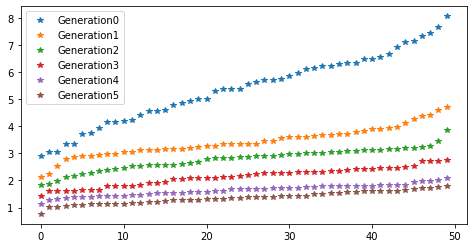

In [9]:
PN = 7
lb = np.zeros( (PN,) );
ub = 5 + np.zeros( (PN,) );
cost_fcn = pattern_cost_function;
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 5;
settings.eliteCount = 1;
settings.selection = 'truncation';

(params, cost, all_params, all_costs) = GA(pattern_cost_function, lb, ub, settings);

plt.figure( figsize=(8,4) )
legs = []
for i in range(len(all_costs)):
    plt.plot( np.arange(all_costs[i].size), all_costs[i], '*' )
    legs.append( "Generation" + str(i) )
plt.legend( legs );